# Predictive regression model with California real estate data

## 1. Setup

In [1]:
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
root_dir = "."
IMAGES_PATH = os.path.join(root_dir, "images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure: ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 2. Get data

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 2.1 Briefly inspect data

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The info() method will show a quick description of the data: number of rows, each attribute's type, number of non-null values, etc.

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


A couple of takeaways:
- The column total_bedrooms only has 20433 non-null variables, so we will have to deal with missing data here.
- All variables are numerical (float64) except for ocean_proximity, which is of type object. Because we have extracted this from a csv file, the nature of this object is likely to be a string.
- When we checked the head of the data frame, we say ocean_proximity to have repetitive (text) values. This indicates it likely to be a categorical attribute. Let's find out more about it.

In [8]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

The describe() method shows a summary of the numerical attributes.

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


To get a feel of the type of data, plot a histogram for each numerical attribute. A histogram shows the number of instances that have a given value range.

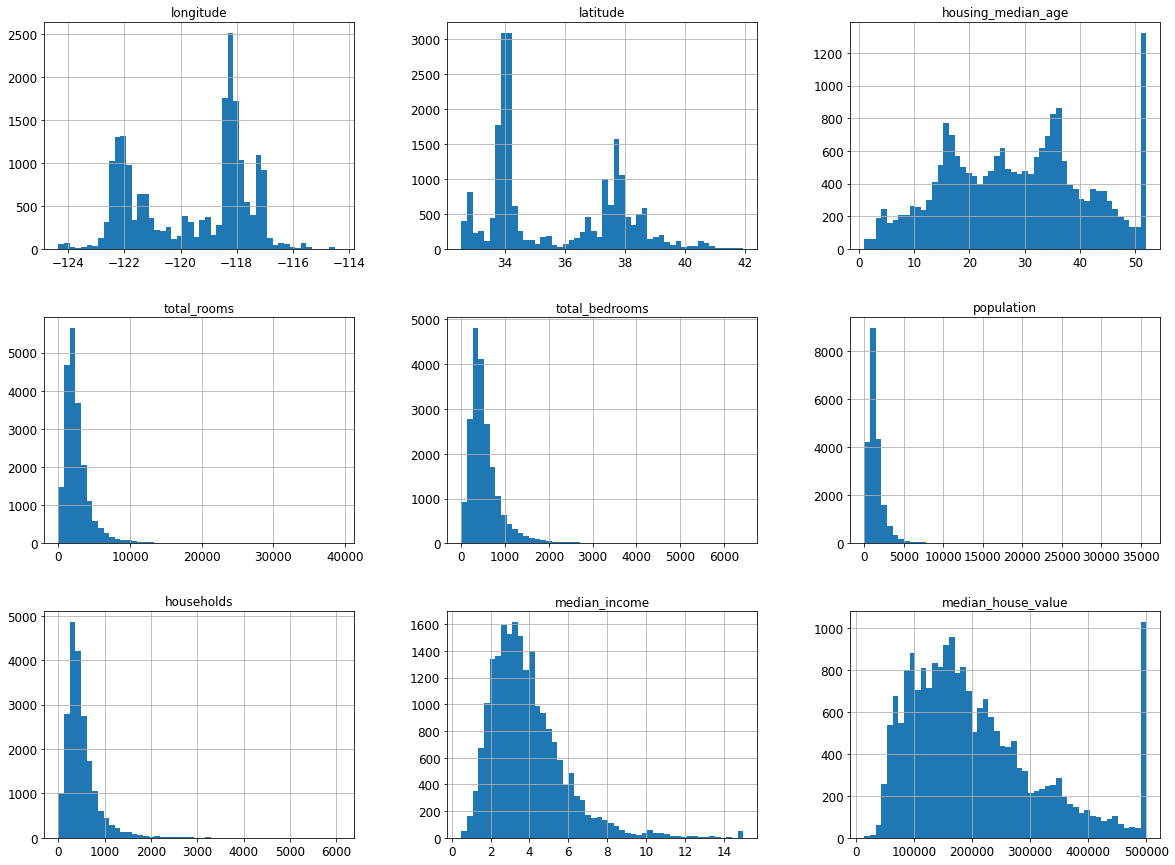

In [10]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

### 2.2 Create a Test Set

In [11]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [12]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train + ", len(test_set), "test")

16512 train +  4128 test


In [14]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")


housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


##### Alternatively

In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


### 2.3 Avoiding sampling bias
If the dataset is not large enough, the notion of random sampling does not apply and there is a risk of introducing sampling bias.
##### Stratified sampling
Divides a set into homogeneous subgroups (called strata) and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall sampled set (e.g. population in polls).
#### How does this apply?
In the case of a continuous numerical attribute, first create categorical attributes ("strata"). This can be derived from histograms. Want to balance the number of instances per stratum, or else one stratum with many instances could be overestimated. In other words, should not have too many strata, and each stratum should be large enough. 
Ensure that the test set is representative of the various categories in the whole dataset.
#### In this case: categorical variable for median income

In [17]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

#### Performing stratified sampling

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

To check if it worked, percentages from test set should be the same as the complete housing set

In [19]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [20]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Evaluate and compare

In [21]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [22]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 3. Discover and Visualize Data

Make sure the test set is put aside and only the training set is explored. 
If the training set is very large, can use only a portion of the set, to make manipulation easier and faster. In this case, the training set is quite small so it's okay.

In [23]:
# Create a copy of training set:
housing = strat_train_set.copy()

Create a scatter plot of all districts using latitude and longitude

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

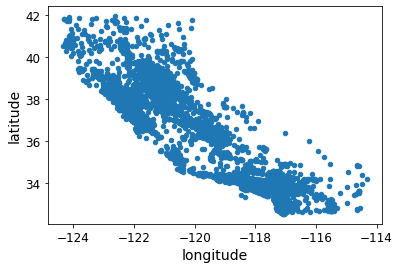

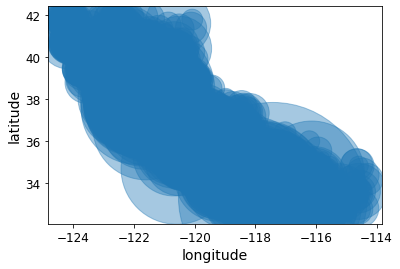

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude")
# Set alpha to 0.1 to visualise places where there is higher density of data points

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"])

Let's look at housing prices. Using a predefined color map (cmap) called jet. 

In [25]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()


NameError: name 'PROJECT_ROOT_DIR' is not defined

### 3.1 Looking for Correlations
Because the dataset is not too large, can compute the standard correlation coefficient (Pearson's r) between every pair of attributes using the corr() method.

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Small reminder that the corr() mehod will only indicate the presence (or absence thereof) of a linear relationship. When it comes to measuring non-linear correlations it is not informative.

Another way to check for correlation between attributes is to use Pandas' scatter_matrix function.

In [ ]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

ModuleNotFoundError: No module named 'pandas.tools'

The relation between median house value and the median income seems promising so let's take a closer look.

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

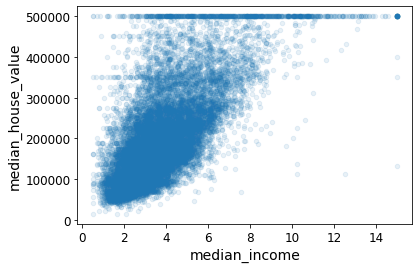

In [26]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

From this we notice a couple of things:

1. Strong correlation: The upwards trend is quite visible and the data points are not very dispersed.
2. There is a noticeable price cap at 500,000 where there is a horizontal line of data points. There are also a few others, though less noticeable, hovering at around 450,000 and 350,000 and possible at 280,000. We may want to remove these districts to prevent the algorithm from overfitting around these.

### 3.2 Experimenting with Attribute Combinations

The total number of rooms in a district is not very useful if we don't know how many households there are. Let's create a new variable for that:

In [27]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]

In [28]:
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

In [29]:
housing["population_per_household"] = housing["population"]/housing["households"]

Take a new look at the correlation matrix

In [30]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [31]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432,-0.028345,0.095603,-0.000410
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724,0.107621,-0.116884,0.005420
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110,-0.147186,0.136788,0.015031
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097,0.127519,-0.192606,-0.024810
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689,0.000377,0.086960,-0.028370
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920,-0.074692,0.037778,0.076225
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506,-0.083009,0.067162,-0.027416
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160,0.311563,-0.624674,0.021822
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000,0.146285,-0.259984,-0.021985
rooms_per_household,-0.028345,0.107621,-0.147186,0.127519,0.000377,-0.074692,-0.083009,0.311563,0.146285,1.000000,-0.398546,-0.005314


## 4. Prepare the Data for Machine Learning Algorithms

Try to write the data clean-up into functions, for reusability, automation and better maintenance.
Revert to a clean training set, and separate the predictors and the labels.

In [32]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### 4.1 Data Cleaning
##### Missing values
There's three options to deal with missing values:

1. Get rid of the corresponding districts. Use DataFrame's dropna() for this.
2. Get rid of the whole attribute. Use DataFrame's drop() for this.
3. Set the values to some value (zero, the mean, the median, etc.). Using DataFrame's fillna(). Should compute the median value on the training set, and use it to fill the missing values in the training set, but save this median value computed. It will be needed later to replace missing values in the test set. And also once the system goes live to replace missing values in the new data.



In [33]:
housing.dropna(subset=["total_bedrooms"])   # option 1 - remove instances without values

housing.drop("total_bedrooms", axis = 1)    # option 2 - remove whole attribute

median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)    # option 3 - fill in with median


17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
          ...  
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, Length: 16512, dtype: float64

Scikit-Learn provides Imputer, to help with missing values. 

In [34]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

# create a numerical copy of the dataset
housing_num = housing.drop("ocean_proximity", axis = 1)

# fit the imputer instance to the training data using the fit() method
imputer.fit(housing_num)

# can use this "trained" imputer to transform the training set (by replacing missing values by the learned medians)
X = imputer.transform(housing_num)

# the result a Numpy array with the transformed features (in this case only bedrooms was missing values)
# back into pandas dataframe:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

ImportError: cannot import name 'Imputer' from 'sklearn.preprocessing' (/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/preprocessing/__init__.py)

### 4.2 Handling Text and Categorical Attributes

To convert text labels into numbers, use Scikit-Learn's transformer called LabelEncoder. 

In [35]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [ ]:
# can also look at the mapping that the encoder learning using the classes_ attribute (first term is 0, next one is 1,etc.)
print(encoder.classes_)

Converting text into numerical attributes can be problematic, because some ML algorithms will assume that two nearby values are more similar than two distant values. However, the text encoded to 0 and 1 are quite dissimilar, whereas the categories 0 and 4 are quite similar. 

One way to overcome this is to use one-hot encoding.
##### One hot encoding
This involves generating a binary attribute for each of the attributes, which will be 1 when the original attribute was present, whilst the remaining binary attributes will then be 0. Thankfully, Scikit-Learn also provides a one-hot encoder.

In [36]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

##### Label Binarizer class
We can apply both transformations: label encoder and one-hot encoder, in one go using Label Binarizer.

In [37]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### 4.3 Custom Transformers

Make these compatible with Scikit-Learn functionalities (such as pipelines). To do this, ensure that the three methods are implemented: fit(), transform() and fit_transform().

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # dont use *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self     # nothing else to do here
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    
    attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
    housing_extra_attribs = attr_adder.transform(housing.values)

NameError: name 'CombinedAttributesAdder' is not defined

### 4.4 Feature Scaling

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=18cf4704-3790-49a3-8d94-41dc8f485b71' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>